In [ ]:
!pip install tensorflow_io

In [ ]:
!pip install tensorflow-addons

In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_io as tfio
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout,LSTM,GlobalAveragePooling1D,BatchNormalization,Conv1D,MaxPooling1D,Concatenate,Flatten,Bidirectional,GRU,GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential
from sklearn.metrics import label_ranking_average_precision_score
import librosa
from tqdm import tqdm

In [ ]:
train_tp=pd.read_csv('/content/drive/MyDrive/Appliedai files/Case_Study_2/train_tp.csv')

In [ ]:
train_tp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [ ]:
yamnet_model_handle= 'https://tfhub.dev/google/yamnet/1'
yamnet_model=hub.load(yamnet_model_handle)

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.
def load_flac_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    #load the raw signal
    audio = tfio.IOTensor.graph(tf.int16).from_audio(filename)
    audio_slice = audio.to_tensor()

    # remove last dimension
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    audio_tensor = tf.cast(audio_tensor, tf.float32)
    sample_rate = tf.cast(48000, dtype=tf.int64)
    #resample the signal tp 16000 sampling rate so that it can be fed to yamnet model
    audio_tensor = tfio.audio.resample(audio_tensor, rate_in=sample_rate, rate_out=16000)
    #getting embeddings
    scores, embeddings, spectrogram = yamnet_model(audio_tensor)
    return embeddings
  


In [ ]:
test_audio,test_spec=load_flac_16k_mono('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/003b04435.flac')

(960000,)


In [ ]:
# Loading the test data files
test = os.listdir('/content/drive/MyDrive/Appliedai files/Case_Study_2/test')

In [ ]:
# Splitting the train true positive data into train and validation
train, validation = train_test_split(train_tp, test_size = 0.1, stratify = train_tp['species_id'])

In [ ]:
# Global variables 
CLASS_N = 24
BATCHSIZE = 8
STEPS_PER_EPOCH = 140 #(train_pts/batch_size)

In [ ]:
train.reset_index(inplace=True)
validation.reset_index(inplace=True)

In [ ]:
def preprocess_train(file):
    """Preprocessing train files"""
    # Calling the preprocess_img function with data_type as train
    
    audio = load_flac_16k_mono('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')
    
    # Computing the one hot encoded values of species_id
    label = tf.one_hot(file['species_id'], CLASS_N)
    # Returning the spectrogram and one hot encoded species_id
    return audio,label


def preprocess_val(file):
    """Preprocessing validation files"""
    # Calling the preprocess_img function with data_type as validation
    audio = load_flac_16k_mono('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')

    # Computing the one hot encoded values of species_id
    label = tf.one_hot(file['species_id'], CLASS_N)
    # Returning the spectrogram and one hot encoded species_id
    return audio, label

    
def preprocess_test(file):
    """Preprocessing test files"""
    # Calling the preprocess_img function with data_type as test
    audio = load_flac_16k_mono('/content/drive/MyDrive/Appliedai files/Case_Study_2/test/'+file)

    file_name = tf.strings.split(file,'.')[0]
    # Returning only the spectrogram image for test dataset 
    return audio,file_name



In [ ]:
# Creating a dataset from train data and mapping the preprocess train function 
files_ds_tr = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = files_ds_tr.map(preprocess_train).cache().shuffle(3).batch(BATCHSIZE).prefetch(-1).repeat()

# Creating a dataset from train data and mapping the preprocess train function 
files_ds_val = tf.data.Dataset.from_tensor_slices(dict(validation))
val_dataset = files_ds_val.map(preprocess_val).cache().shuffle(3).batch(BATCHSIZE).prefetch(-1)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
def lwlrap(y_true, y_pred):
    return tf.py_function(label_ranking_average_precision_score, (y_true, y_pred), tf.double)

## LSTM Model

In [ ]:
#Train a NN classifier with embedding features
def lstm_model():

  input_layer= Input(shape=(124,1024), name='Input_layer')
  lstm_layer= LSTM(512,return_sequences=True)(inputs=input_layer)
  td=GlobalAveragePooling1D()(lstm_layer)
  dense_2= Dense(324, activation='relu',kernel_initializer='he_normal')(td)
  drop_out1= Dropout(0.7)(dense_2)
  dense_3= Dense(128, activation='relu',kernel_initializer='he_normal')(drop_out1)
  drop_out2= Dropout(0.5)(dense_3)
  dense_4=Dense(64, activation='relu',kernel_initializer='he_normal')(drop_out2)
  dense_5=Dense(32, activation='relu',kernel_initializer='he_normal')(dense_4)
  output= Dense(CLASS_N, activation='sigmoid')(dense_5)
  model= Model(inputs=[input_layer], outputs=[output])

  opt=tf.keras.optimizers.Adam()  # Optimizer
  model.compile(optimizer=opt, loss='binary_crossentropy',metrics=[lwlrap])

  return model
  
model=lstm_model()
model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 124, 1024)]       0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 124, 512)          3147776   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 324)               166212    
_________________________________________________________________
dropout_8 (Dropout)          (None, 324)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               41600     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0   

In [ ]:
#loading tensorboard
%load_ext tensorboard
!rm -rf ./logs/
from datetime import datetime
#creating log directory
logdir="logs/scalars_2/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard callback
tensorboard_1 = TensorBoard(log_dir=logdir)
earlystop= EarlyStopping(monitor='val_lwlrap', patience=20,mode='max')
lrdecay=ReduceLROnPlateau(monitor='val_lwlrap',factor=0.9,patience=4,mode='max')


#Path for saving model
filepath="/content/drive/MyDrive/Appliedai files/Case_Study_2/model_1/weights-{epoch:02d}-{val_lwlrap:.4f}.hdf5"
#Model checkpoint callback
checkpoint_1 = ModelCheckpoint(filepath=filepath, monitor='val_lwlrap', save_best_only=True, verbose=1, mode='max', save_freq='epoch')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
model.fit(train_dataset,steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_dataset,epochs = 150,callbacks=[earlystop,lrdecay,tensorboard_1,checkpoint_1])

Epoch 1/150
140/140 [==============================] - 6s 31ms/step - loss: 0.2521 - lwlrap: 0.1628 - val_loss: 0.1871 - val_lwlrap: 0.2133

Epoch 00001: val_lwlrap improved from -inf to 0.21332, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/model_1/weights-01-0.2133.hdf5
Epoch 2/150
140/140 [==============================] - 4s 25ms/step - loss: 0.1876 - lwlrap: 0.1965 - val_loss: 0.1913 - val_lwlrap: 0.2339

Epoch 00002: val_lwlrap improved from 0.21332 to 0.23391, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/model_1/weights-02-0.2339.hdf5
Epoch 3/150
140/140 [==============================] - 4s 25ms/step - loss: 0.1814 - lwlrap: 0.2181 - val_loss: 0.1745 - val_lwlrap: 0.2566

Epoch 00003: val_lwlrap improved from 0.23391 to 0.25655, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/model_1/weights-03-0.2566.hdf5
Epoch 4/150
140/140 [==============================] - 4s 26ms/step - loss: 0.1751 - lwlrap: 0.2328 - val_los

In [ ]:
%tensorboard --logdir /content/logs/scalars_2

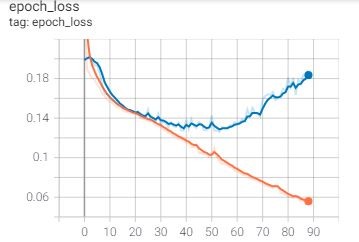

In [1]:
#Loss and metric plots

from IPython.display import Image
Image(filename='/content/drive/MyDrive/lstm_loss.JPG')

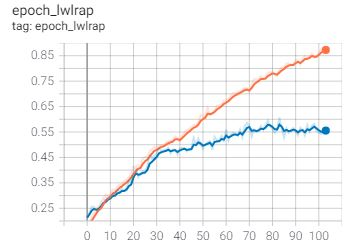

In [2]:
Image(filename='/content/drive/MyDrive/lstm_metric.JPG')

## CRNN

In [ ]:

def crnn_model():

  input_layer=Input(shape=(124,1024))   # Input layer
  lstm_layer=LSTM(units=128,return_sequences=True)(input_layer)  # LSTM layer with 25 units
  average=GlobalAveragePooling1D()(lstm_layer) #Global average pool
  layer_1=Dense(128,activation='relu')(average) # Dense layer


  x=Conv1D(filters=48,kernel_size=5)(input_layer)
  x=MaxPooling1D(strides=2)(x)
  x=Activation('relu')(x)
  x=Conv1D(filters=56,kernel_size=5)(input_layer)
  x=MaxPooling1D(strides=2)(x)
  x=Activation('relu')(x)
  x=Conv1D(filters=64,kernel_size=5)(x)
  x=MaxPooling1D(strides=2)(x)
  x=Activation('relu')(x)
  x=Conv1D(filters=72,kernel_size=5)(x)
  x=GlobalAveragePooling1D()(x)
  x=Dense(64,activation='relu')(x) # Dense layer

  x=Concatenate()([layer_1,x])
  x=Dense(64)(x)
  x=Dropout(0.3)(x)
  output=Dense(24,activation='sigmoid')(x)

  model = Model(inputs=[input_layer],outputs=output)
  opt=tfa.optimizers.RectifiedAdam(learning_rate=2e-4,total_steps=65*140,warmup_proportion=0.3,min_lr=1e-6)
  #optimizer=tf.keras.optimizers.Adam()  # Optimizer
  model.compile(optimizer=opt, loss='binary_crossentropy',metrics=[lwlrap])

  return model

In [ ]:
#model_input= Input(shape=(124,1024))
model_3= crnn_model()
model_3.run_eagerly = True
print(model_3.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 124, 1024)]  0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 120, 56)      286776      input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 60, 56)       0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 60, 56)       0           max_pooling1d_7[0][0]            
____________________________________________________________________________________________

In [ ]:
#loading tensorboard
%load_ext tensorboard
!rm -rf ./logs/
from datetime import datetime
#creating log directory
logdir="logs/scalars_1/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard callback
tensorboard_2 = TensorBoard(log_dir=logdir)
earlystop= EarlyStopping(monitor='val_lwlrap', patience=20,mode='max')
lrdecay=ReduceLROnPlateau(monitor='val_lwlrap',factor=0.1,patience=4,mode='max')


#Path for saving model
filepath="/content/drive/MyDrive/Appliedai files/Case_Study_2/model_2/weights-{epoch:02d}-{val_lwlrap:.4f}.hdf5"
#Model checkpoint callback
checkpoint_2 = ModelCheckpoint(filepath=filepath, monitor='val_lwlrap', save_best_only=True, verbose=1, mode='max', save_freq='epoch')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:

#model_3.compile(optimizer='adam',loss='binary_crossentropy', metrics=[lwlrap])
model_3.fit(train_dataset,steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_dataset,epochs = 80,callbacks=[earlystop,tensorboard_2,checkpoint_2])

Epoch 1/80
140/140 [==============================] - 12s 87ms/step - loss: 0.8680 - lwlrap: 0.1572 - val_loss: 0.7735 - val_lwlrap: 0.1860

Epoch 00001: val_lwlrap improved from -inf to 0.18601, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/model_2/weights-01-0.1860.hdf5
Epoch 2/80
140/140 [==============================] - 11s 82ms/step - loss: 0.7000 - lwlrap: 0.1604 - val_loss: 0.5987 - val_lwlrap: 0.1848

Epoch 00002: val_lwlrap did not improve from 0.18601
Epoch 3/80
140/140 [==============================] - 11s 77ms/step - loss: 0.5319 - lwlrap: 0.1700 - val_loss: 0.4329 - val_lwlrap: 0.1871

Epoch 00003: val_lwlrap improved from 0.18601 to 0.18707, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/model_2/weights-03-0.1871.hdf5
Epoch 4/80
140/140 [==============================] - 11s 77ms/step - loss: 0.3820 - lwlrap: 0.1703 - val_loss: 0.2883 - val_lwlrap: 0.2292

Epoch 00004: val_lwlrap improved from 0.18707 to 0.22924, saving model t

In [ ]:
%tensorboard --logdir /content/logs/scalars_1

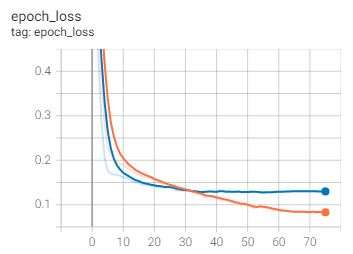

In [3]:
Image(filename='/content/drive/MyDrive/crnn_loss.JPG')

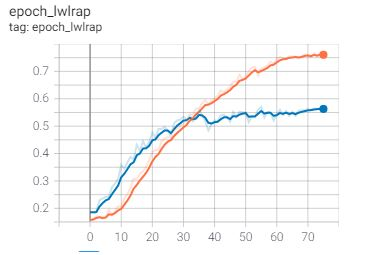

In [4]:
Image(filename='/content/drive/MyDrive/crnn_metric.JPG')

## Parallel CNN Architecture

In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.
def load_flac_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    #load the raw signal
    audio = tfio.IOTensor.graph(tf.int16).from_audio(filename)
    audio_slice = audio.to_tensor()

    # remove last dimension
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    audio_tensor = tf.cast(audio_tensor, tf.float32)
    sample_rate = tf.cast(48000, dtype=tf.int64)
    #resample the signal tp 16000 sampling rate so that it can be fed to yamnet model
    audio_tensor = tfio.audio.resample(audio_tensor, rate_in=sample_rate, rate_out=16000)
    #getting embeddings
    scores, embeddings, spectrogram = yamnet_model(audio_tensor)
    return embeddings,spectrogram

In [ ]:
#Data generator for spectrogram and embeddings input
def train_generator(k=len(train)):
  for i in range(k):
    embed,spec = load_flac_16k_mono('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+train['recording_id'][i]+'.flac')
    embed=tf.reshape(embed,shape=(1,124,1024))
    spec=tf.reshape(spec,shape=(1,6000,64))
    inputs=(spec,embed)
    output=train['species_id'][i]
    output=tf.keras.utils.to_categorical(output, num_classes=24)
    output=tf.reshape(output,shape=(1,24))
    yield inputs,output

def val_generator(k=len(validation)):
  for i in range(k):
    embed,spec = load_flac_16k_mono('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+validation['recording_id'][i]+'.flac')
    embed=tf.reshape(embed,shape=(1,124,1024))
    spec=tf.reshape(spec,shape=(1,6000,64))
    inputs=(spec,embed)
    output=validation['species_id'][i]
    output=tf.keras.utils.to_categorical(output, num_classes=24)
    output=tf.reshape(output,shape=(1,24))
    yield inputs,output

types=((tf.float32,tf.float32),(tf.int32))
#shapes=(([None,6000,64],[None,124,1024]),
          #([None,24]))

train_data = tf.data.Dataset.from_generator(train_generator,output_types=types)

val_data = tf.data.Dataset.from_generator(val_generator,output_types=types)

In [ ]:
nb_filters1=32
nb_filters2=32 
nb_filters3=32
ksize =5
pool_size_1= 2
pool_size_2= 4
pool_size_3 =2

dropout_prob = 0.3
dense_size1 = 128
lstm_count = 96
num_units = 120

BATCH_SIZE = 64
EPOCH_COUNT = 50
L2_regularization = 0.001
num_classes=24

def cnn_rnn_parallel():
    print('Building model...')
    inp_layer_1 = Input(shape=(6000,64),name='conv_input')
    
    ### Convolutional blocks
    conv_1 = Conv1D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(inp_layer_1)
    pool_1 = MaxPooling1D(pool_size_1)(conv_1)
    drop_1=Dropout(dropout_prob)(pool_1)

    conv_2 = Conv1D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(drop_1)
    pool_2 = MaxPooling1D(pool_size_1)(conv_2)
    drop_2=Dropout(dropout_prob)(pool_2)

    conv_3 = Conv1D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(drop_2)
    pool_3 = MaxPooling1D(pool_size_1)(conv_3)

   

    flatten1 = GlobalMaxPooling1D()(pool_3)
    ### Recurrent Block
    
    inp_layer_2=Input(shape=(124,1024))
    # Bidirectional GRU
    lstm = LSTM(lstm_count,return_sequences=True)(inp_layer_2)  #default merge mode is concat
    
    flatten2=GlobalMaxPooling1D()(lstm)
    # Concat Output
    concat = Concatenate()([flatten1, flatten2])
    
    ## Softmax Output
    dense_2 = Dense(64, activation = 'relu')(concat)
    drop_3=Dropout(dropout_prob)(dense_2)
    output = Dense(num_classes, activation = 'sigmoid', name='preds')(drop_3)
    
    model = Model(inputs=[inp_layer_1,inp_layer_2],outputs=[output])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[lwlrap])

    return model
    
model_2=cnn_rnn_parallel()
model_2.run_eagerly = True
print(model_2.summary())

Building model...
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_input (InputLayer)         [(None, 6000, 64)]   0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 5996, 32)     10272       conv_input[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 2998, 32)     0           conv_1[0][0]                     
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2998, 32)     0           max_pooling1d_9[0][0]            
__________________________________________________________________________

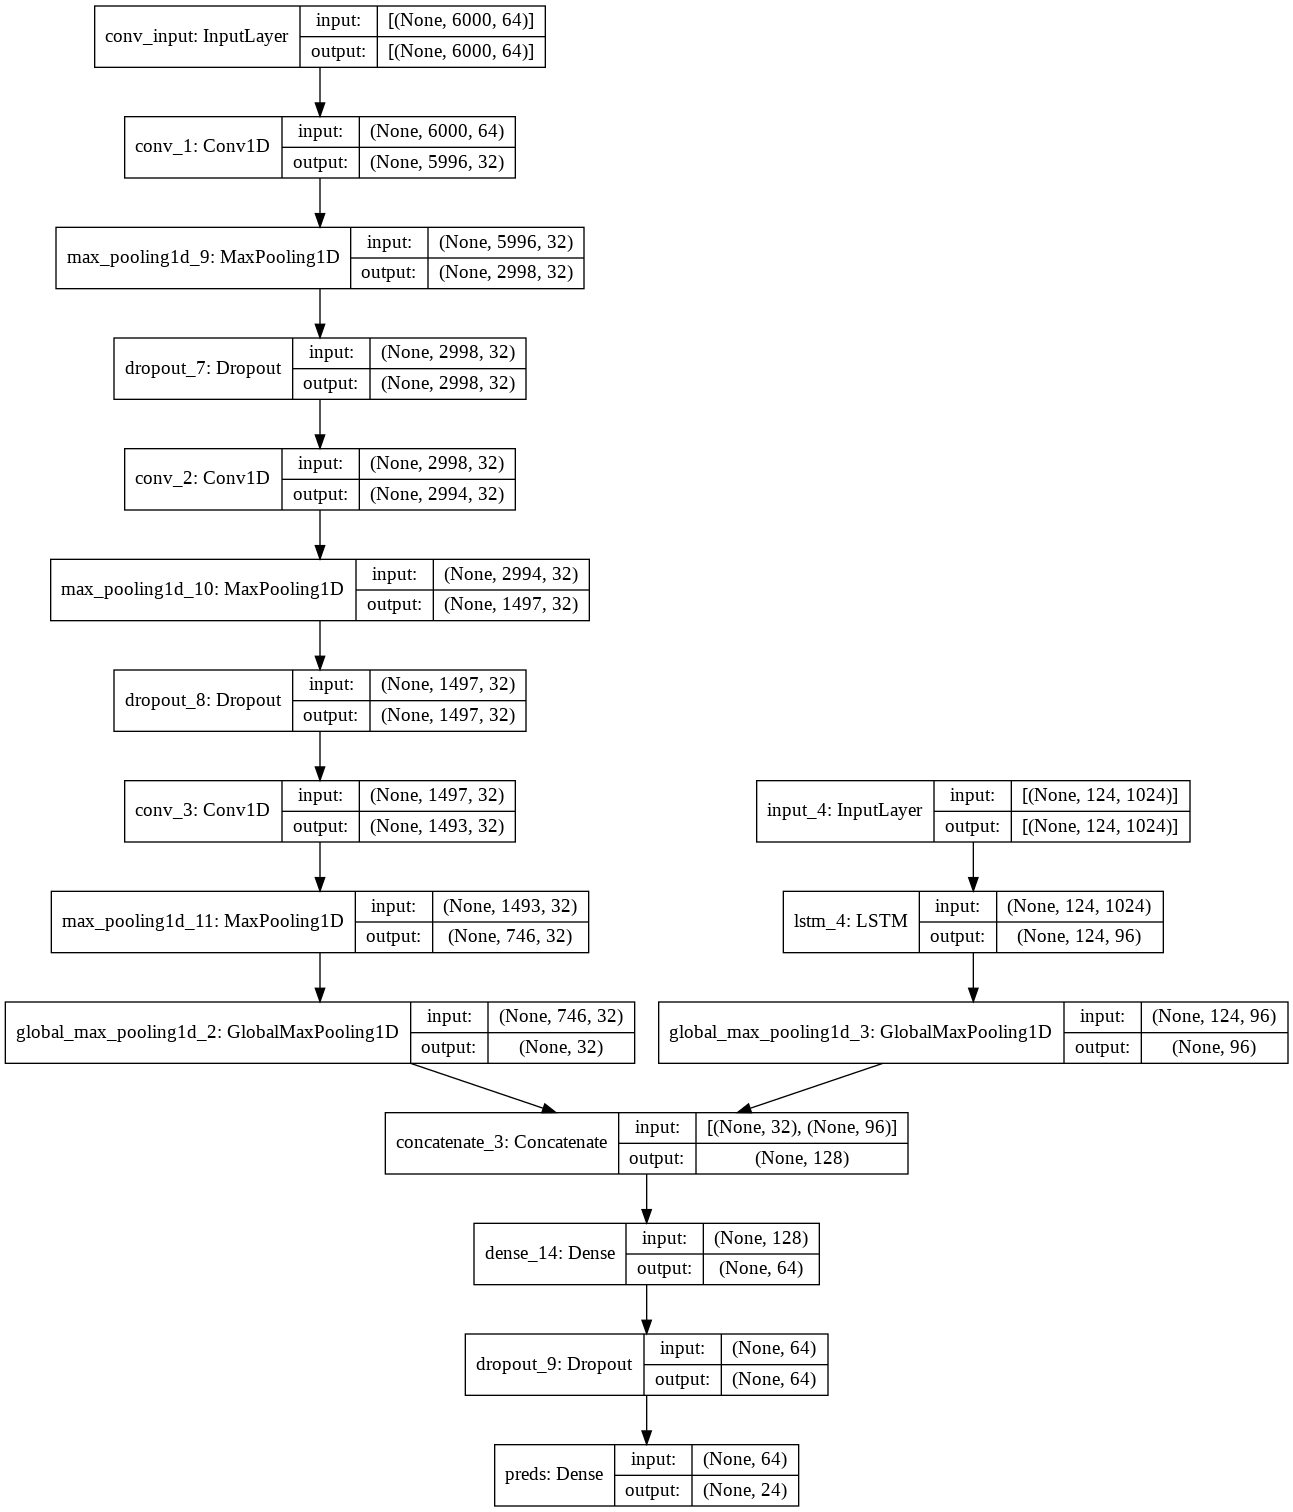

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='/content/drive/MyDrive/Appliedai files/Case_Study_2/model_6.png', show_shapes=True, show_layer_names=True)


In [ ]:
#Path for saving model
filepath="/content/drive/MyDrive/Appliedai files/Case_Study_2/model_3/weights-{epoch:02d}-{val_lwlrap:.4f}.hdf5"
#Model checkpoint callback
checkpoint_3 = ModelCheckpoint(filepath=filepath, monitor='val_lwlrap', save_best_only=True, verbose=1, mode='max', save_freq='epoch')

#loading tensorboard
%load_ext tensorboard
!rm -rf ./logs/
from datetime import datetime
#creating log directory
logdir="logs/scalars_2/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard callback
tensorboard_2 = TensorBoard(log_dir=logdir)
earlystop= EarlyStopping(monitor='val_lwlrap', patience=15,mode='max')


lrdecay=ReduceLROnPlateau(monitor='val_lwlrap',factor=0.9,patience=4,mode='max')

In [ ]:
model_2.fit(train_data, validation_data=val_data,epochs = 65,callbacks=[lrdecay,checkpoint_3,tensorboard_2,earlystop])

Epoch 1/65
      4/Unknown - 22s 1s/step - loss: 0.9972 - lwlrap: 0.2917WARNING:tensorflow:5 out of the last 5 calls to <function pfor.<locals>.f at 0x7ff6a6fe0710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


      5/Unknown - 23s 1s/step - loss: 0.8718 - lwlrap: 0.4334WARNING:tensorflow:6 out of the last 6 calls to <function pfor.<locals>.f at 0x7ff6a7445e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1094/1094 [==============================] - 1080s 972ms/step - loss: 0.2054 - lwlrap: 0.1970 - val_loss: 0.1617 - val_lwlrap: 0.2753

Epoch 00001: val_lwlrap improved from -inf to 0.27530, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/model_3/weights-01-0.2753.hdf5
Epoch 2/65
1094/1094 [==============================] - 237s 216ms/step - loss: 0.1694 - lwlrap: 0.2641 - val_loss: 0.1539 - val_lwlrap: 0.3238

Epoch 00002: val_lwlrap improved from 0.27530 to 0.32378, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/model_3/weights-02-0.3238.hdf5
Epoch 3/65
1094/1094 [==============================] - 237s 216ms/step - loss: 0.1615 - lwlrap: 0.2958 - val_loss: 0.1458 - val_lwlrap: 0.4162

Epoch 00003: val_lwlrap improved from 0.32378 to 0.41622, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/model_3/weights-03-0.4162.hdf5
Epoch 4/65
1094/1094 [==============================] - 236s 216ms/step - loss: 0.1529 - lwlrap: 0.3554 - v